In [1]:
!pip install wget
import wget

wget.download("https://github.com/GrandmaCan/ML/raw/main/Classification/one_piece_mini.zip")

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=96b525d59e6dc1a7bdb43607fe6c7a4693607922e2b5b8ca6483ba2dfbbe3c7a
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


'one_piece_mini.zip'

In [2]:
import zipfile

with zipfile.ZipFile("one_piece_mini.zip", "r") as zip_file:
  zip_file.extractall("one_piece_mini")

In [3]:
from torch.utils.data import Dataset
from pathlib import Path
from PIL import Image
from torchvision import transforms

class ImageDataset(Dataset):
  def __init__(self, root, train, transform=None):

    if train:
      image_root = Path(root) / "train"
    else:
      image_root = Path(root) / "test"

    with open(Path(root) / "classnames.txt", "r") as f:
      lines = f.readlines()
      self.classes = [line.strip() for line in lines]

    self.paths = [i for i in image_root.rglob("*") if i.is_file()]
    self.transform = transform

  def __getitem__(self, index):
    img = Image.open(self.paths[index]).convert("RGB")
    class_name = self.paths[index].parent.name
    class_idx = self.classes.index(class_name)

    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx


  def __len__(self):
    return len(self.paths)

In [4]:
train_transforms = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.TrivialAugmentWide(),
  transforms.ToTensor()
])

test_transforms = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

In [5]:
train_dataset = ImageDataset("one_piece_mini", train=True, transform=train_transforms)
train_dataset.classes
x, y = train_dataset[200]
x.shape, y

(torch.Size([3, 64, 64]), 0)

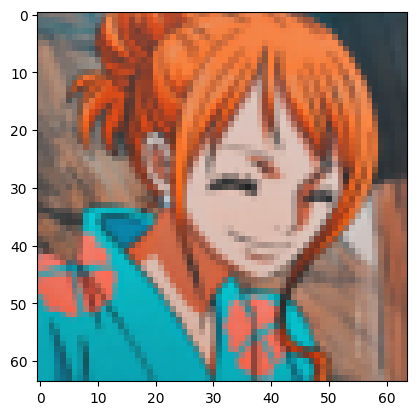

In [6]:
import matplotlib.pyplot as plt

x, y = train_dataset[100]
plt.imshow(x.permute(1, 2, 0))

In [7]:
train_dataset = ImageDataset(root="one_piece_mini",
                train=True,
                transform=train_transforms
)

test_dataset = ImageDataset(root="one_piece_mini",
                train=False,
                transform=test_transforms
)

In [8]:
len(train_dataset), len(test_dataset)

(240, 60)

In [9]:
x, y = test_dataset[0]
x.shape, y

(torch.Size([3, 64, 64]), 2)

In [10]:
from torch.utils.data import DataLoader

BATCH_SIZE = 8

train_dataloader = DataLoader(dataset=train_dataset,
                batch_size=BATCH_SIZE,
                shuffle=True
)

test_dataloader = DataLoader(dataset=test_dataset,
                batch_size=BATCH_SIZE,
                shuffle=False
)

In [11]:
len(train_dataloader), len(test_dataloader)

(30, 8)

In [12]:
x_first_batch, y_first_batch = next(iter(train_dataloader))
x_first_batch[0].shape, y_first_batch[0]

(torch.Size([3, 64, 64]), tensor(0))

In [13]:
from torch import nn
class ImageClassificationModel3(nn.Module):
  def __init__(self, input_shape, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape,
          out_channels=8,
          kernel_size=(3, 3),
          stride=1,
          padding=1
      ),
      nn.ReLU(),
      nn.Conv2d(in_channels=8,
          out_channels=8,
          kernel_size=(3, 3),
          stride=1,
          padding=1
      ),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2, 2),
            stride=2,
            padding=0
      )
    )

    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=8,
          out_channels=16,
          kernel_size=(3, 3),
          stride=1,
          padding=1
      ),
      nn.ReLU(),
      nn.Conv2d(in_channels=16,
          out_channels=16,
          kernel_size=(3, 3),
          stride=1,
          padding=1
      ),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2, 2),
            stride=2,
            padding=0
      )
    )

    self.classifier = nn.Sequential(
      nn.Flatten(start_dim=1, end_dim=-1),
      nn.Linear(in_features=16*16*16, out_features=output_shape)
    )
  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [14]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
model = ImageClassificationModel3(3, len(train_dataset.classes))
model.to(device)
model(x_first_batch.to(device))

tensor([[-0.0083,  0.0439,  0.0508],
        [-0.0072,  0.0456,  0.0492],
        [-0.0056,  0.0430,  0.0519],
        [-0.0060,  0.0440,  0.0452],
        [-0.0048,  0.0464,  0.0498],
        [-0.0063,  0.0450,  0.0489],
        [-0.0059,  0.0492,  0.0473],
        [-0.0074,  0.0424,  0.0475]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [16]:
cost_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [17]:
def accuracy_fn(y_pred, y_true):

  correct_num = (y_pred==y_true).sum()
  acc = correct_num / len(y_true) * 100

  return acc

In [18]:
def train_step(dataloader, model, cost_fn, optimizer, accuracy_fn, device):
  train_cost = 0
  train_acc = 0
  for batch, (x, y) in enumerate(dataloader):
    x = x.to(device)
    y = y.to(device)

    model.train()

    y_pred = model(x)

    cost = cost_fn(y_pred, y)

    train_cost += cost
    train_acc += accuracy_fn(y_pred.argmax(dim=1), y)

    optimizer.zero_grad()

    cost.backward()

    optimizer.step()

  train_cost /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  print(f"\nTrain Cost: {train_cost:.4f}, Train Acc: {train_acc:.2f}")


def test_step(dataloader, model, cost_fn, accuracy_fn, device):
  test_cost = 0
  test_acc = 0
  model.eval()
  with torch.inference_mode():
    for x, y in dataloader:
      x = x.to(device)
      y = y.to(device)

      test_pred = model(x)

      test_cost += cost_fn(test_pred, y)
      test_acc += accuracy_fn(test_pred.argmax(dim=1), y)

    test_cost /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"Test Cost: {test_cost:.4f}, Test Acc: {test_acc:.2f} \n")

In [19]:
from tqdm.auto import tqdm

epochs = 10

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")

  train_step(train_dataloader, model, cost_fn, optimizer, accuracy_fn, device)

  test_step(test_dataloader, model, cost_fn, accuracy_fn, device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------

Train Cost: 1.1106, Train Acc: 31.25
Test Cost: 1.0925, Test Acc: 37.50 

Epoch: 1
-------

Train Cost: 1.0915, Train Acc: 34.17
Test Cost: 1.0701, Test Acc: 56.25 

Epoch: 2
-------

Train Cost: 1.0857, Train Acc: 34.17
Test Cost: 1.0687, Test Acc: 56.25 

Epoch: 3
-------

Train Cost: 1.0223, Train Acc: 47.50
Test Cost: 1.1600, Test Acc: 29.69 

Epoch: 4
-------

Train Cost: 0.9751, Train Acc: 53.75
Test Cost: 0.9251, Test Acc: 67.19 

Epoch: 5
-------

Train Cost: 0.9361, Train Acc: 60.83
Test Cost: 0.9225, Test Acc: 70.31 

Epoch: 6
-------

Train Cost: 0.8944, Train Acc: 63.75
Test Cost: 0.8012, Test Acc: 67.19 

Epoch: 7
-------

Train Cost: 0.7572, Train Acc: 71.25
Test Cost: 0.8911, Test Acc: 57.81 

Epoch: 8
-------

Train Cost: 0.7384, Train Acc: 69.17
Test Cost: 0.7685, Test Acc: 73.44 

Epoch: 9
-------

Train Cost: 0.8222, Train Acc: 68.33
Test Cost: 0.7384, Test Acc: 82.81 



In [20]:
img = Image.open("nami.jpg").convert("RGB")
img = test_transforms(img)
img = img.reshape(-1, 3, 64, 64)
img.shape
model.eval()
with torch.inference_mode():
  y_pred = model(img.to(device))
y_pred = torch.softmax(y_pred, dim=1)
class_idx = y_pred.argmax(dim=1)
train_dataset.classes[class_idx]

FileNotFoundError: [Errno 2] No such file or directory: 'nami.jpg'

In [ ]:
import requests

url = "https://firebasestorage.googleapis.com/v0/b/grandmacan-2dae4.appspot.com/o/ML_data%2Fone_piece_full.zip?alt=media&token=937656fd-f5c1-44f5-b174-1e2d590b8ef3"

with open("one_piece_full.zip", "wb") as f:
  req = requests.get(url)
  f.write(req.content)

In [ ]:
import zipfile

with zipfile.ZipFile("one_piece_full.zip", "r") as zip_file:
  zip_file.extractall("one_piece_full")

In [ ]:
train_dataset = ImageDataset(root="one_piece_full",
                train=True,
                transform=train_transforms
)

test_dataset = ImageDataset(root="one_piece_full",
                train=False,
                transform=test_transforms
)

In [ ]:
len(train_dataset), len(test_dataset)

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_dataloader = DataLoader(dataset=train_dataset,
                batch_size=BATCH_SIZE,
                shuffle=True
)

test_dataloader = DataLoader(dataset=test_dataset,
                batch_size=BATCH_SIZE,
                shuffle=False
)

In [ ]:
len(train_dataloader), len(test_dataloader)

In [ ]:
model_2 = ImageClassificationModel3(3, len(train_dataset.classes))
model_2.to(device)

In [ ]:
cost_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001)

In [ ]:
from tqdm.auto import tqdm

epochs = 10

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")

  train_step(train_dataloader, model_2, cost_fn, optimizer, accuracy_fn, device)

  test_step(test_dataloader, model_2, cost_fn, accuracy_fn, device)
